In [34]:
import Pkg
Pkg.update()

pkgs = [
    "Revise",
    "MetaGraphs",
    "Graphs",
    "JSON",
    "uCSV",
    "DataFrames",
    "Dates",
    "Primes"
]

Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end

# Pkg.add(url="https://github.com/cjprybol/Mycelia.git", rev="master")
# Pkg.develop(path="$(homedir())/workspace/Mycelia")
import Mycelia

    Updating registry at `/opt/julia/registries/General`
  No Changes to `~/work/Mycelia/Project.toml`
  No Changes to `~/work/Mycelia/Manifest.toml`
   Resolving package versions...
  No Changes to `~/work/Mycelia/Project.toml`
  No Changes to `~/work/Mycelia/Manifest.toml`


In [25]:
#papermill parameters
base_directory = "$(homedir())/workspace/sars-cov2-pangenome-analysis/"
sequences_directory = "$(base_directory)/data/sequences"
metadata_file = "$(base_directory)/metadata/sequences.csv"
working_directory = "$(homedir())/workspace/scratch/$(Dates.today())"

"/home/jovyan/workspace/scratch/2022-09-10"

In [26]:
mkpath(working_directory)
cd(working_directory)

In [10]:
# f = metadata_file
f = open(`head $metadata_file`)
@time sequence_metadata = DataFrames.DataFrame(uCSV.read(f, quotes='"', header=1, typedetectrows=100)...)

  1.057389 seconds (1.65 M allocations: 94.945 MiB, 99.81% compilation time)


,Accession,SRA_Accession,Submitters
,String,String,String
1,NC_045512.2,,"Wu,F., Zhao,S., Yu,B., Chen,Y.M., Wang,W., Song,Z.G., Hu,Y., Tao,Z.W., Tian,J.H., Pei,Y.Y., Yuan,M.L., Zhang,Y.L., Dai,F.H., Liu,Y., Wang,Q.M., Zheng,J.J., Xu,L., Holmes,E.C., Zhang,Y.Z., Baranov,P.V., Henderson,C.M., Anderson,C.B., Gesteland,R.F., Atkins,J.F., Howard,M.T., Robertson,M.P., Igel,H., Baertsch,R., Haussler,D., Ares,M. Jr., Scott,W.G., Williams,G.D., Chang,R.Y., Brian,D.A., Chen,Y.-M., Song,Z.-G., Tao,Z.-W., Tian,J.-H., Pei,Y.-Y., Zhang,Y.-L., Dai,F.-H., Wang,Q.-M., Zheng,J.-J., Zhang,Y.-Z."
2,OP164776.1,,"Afrad Moon,M.H., Qadri,F."
3,OP164777.1,,"Afrad Moon,M.H., Qadri,F."
4,OP164778.1,,"Afrad Moon,M.H., Qadri,F."
5,OP164779.1,,"Afrad Moon,M.H., Qadri,F."
6,OP164780.1,,"Afrad Moon,M.H., Qadri,F."
7,OP164781.1,,"Afrad Moon,M.H., Qadri,F."
8,OP164782.1,,"Afrad Moon,M.H., Qadri,F."
9,OP164783.1,,"Afrad Moon,M.H., Qadri,F."


In [11]:
readdir(sequences_directory)

2271461-element Vector{String}:
 ".ipynb_checkpoints"
 "BS002449.1.fna"
 "BS002450.1.fna"
 "BS002451.1.fna"
 "BS002452.1.fna"
 "BS002453.1.fna"
 "BS002454.1.fna"
 "BS002455.1.fna"
 "BS002456.1.fna"
 "BS002457.1.fna"
 "BS002458.1.fna"
 "BS002459.1.fna"
 "BS002460.1.fna"
 ⋮
 "PA368302.1.fna"
 "PA368303.1.fna"
 "PA368304.1.fna"
 "PA368305.1.fna"
 "PA368306.1.fna"
 "PA368307.1.fna"
 "PA368308.1.fna"
 "PA368309.1.fna"
 "PA543310.1.fna"
 "PA543487.1.fna"
 "PA544048.1.fna"
 "PA544053.1.fna"

In [14]:
fastx_files = map(x -> "$(sequences_directory)/$(x).fna", sequence_metadata[!, "Accession"])

9-element Vector{String}:
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/NC_045512.2.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164776.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164777.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164778.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164779.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164780.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164781.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164782.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164783.1.fna"

kmer_type = Kmers.Kmer{BioSequences.DNAAlphabet{2}, 3, 1}
(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 123], [0, 1, 7, 29, 32], false)


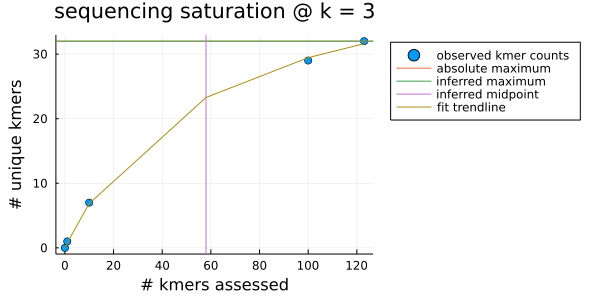

  3.857442 seconds (9.48 M allocations: 549.306 MiB, 3.09% gc time, 99.60% compilation time)
(k, predicted_saturation) = (3, 1.0)
kmer_type = Kmers.DNAKmer{5, 1}


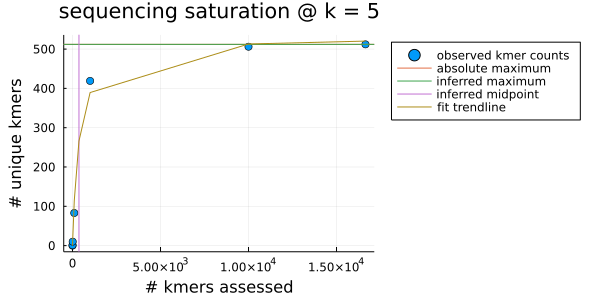

(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 10000, 16646], [0, 1, 10, 83, 419, 506, 512], false)
  0.000069 seconds (335 allocations: 37.000 KiB)
(k, predicted_saturation) = (5, 1.0)
kmer_type = Kmers.DNAKmer{7, 1}
(sampling_points, kmer_counts, hit_eof) = 

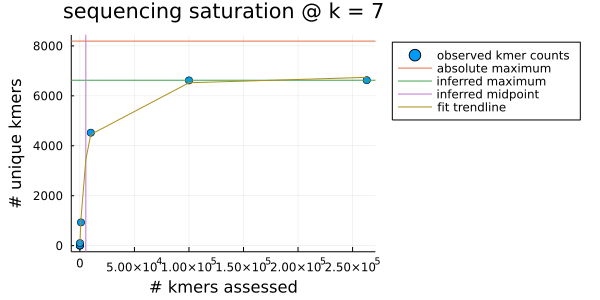

([0, 1, 10, 100, 1000, 10000, 100000, 262989], [0, 1, 10, 99, 929, 4522, 6617, 6625], true)
  0.000061 seconds (234 allocations: 25.609 KiB)
(k, predicted_saturation) = (7, 0.8087158203125)
kmer_type = Kmers.DNAKmer{11, 1}


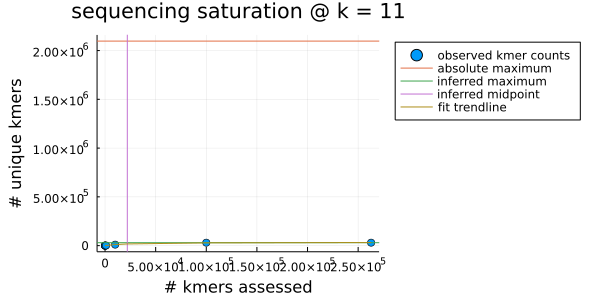

(sampling_points, kmer_counts, hit_eof) = ([0, 1, 10, 100, 1000, 10000, 100000, 262801], [0, 1, 10, 100, 999, 9935, 30003, 30136], true)
  0.000062 seconds (313 allocations: 34.578 KiB)
(k, predicted_saturation) = (11, 0.014369964599609375)
chosen k = 11


11

In [22]:
kmer_size = Mycelia.assess_dnamer_saturation(fastx_files)

In [ ]:
# import BioSequences
# import FASTX
# import Kmers

In [15]:
graph = Mycelia.initialize_graph()
graph = Mycelia.add_fastx_to_graph!(graph, fastx_files)

{9, 0} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [17]:
# run(`conda install -c bioconda bcalm`)

In [51]:
fastx_files

9-element Vector{String}:
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/NC_045512.2.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164776.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164777.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164778.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164779.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164780.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164781.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164782.1.fna"
 "/home/jovyan/workspace/sars-cov2-pangenome-analysis//data/sequences/OP164783.1.fna"

In [66]:
# fasta_file_list = joinpath(working_directory, repr(hash(fastx_files)) * ".fasta_list.txt")
# open(fasta_file_list, "w") do io
#     for f in fastx_files
#         @show f
#         println(io, f)
#     end
# end

In [37]:
Primes.primes(3, kmer_size)

4-element Vector{Int64}:
  3
  5
  7
 11

In [67]:
# k = 3
# outfile = fasta_file_list * ".bcalm.$(k).fna"
# cmd = `bcalm -in $(fastx_files[1]) -abundance-min 1 -kmer-size 11 -all-abundance-counts -out $(outfile)`
# run(cmd)

# cmds = [
#     `bcalm`,
#     `-in $(fasta_list_file)`,
#     `-abundance-min 1`,
#     `-kmer-size 3`,
#     `-all-abundance-counts`,
#     `-abundance-max $(typemax(UInt64))`
# ]
# run(cmds)

In [ ]:
# ls -1 *.fastq > list_reads
# ./bcalm -in list_reads [..]
# ./bcalm -in [reads.fa] -kmer-size [kmer_size] -abundance-min [abundance_threshold]

In [ ]:
# scripts/convertToGFA.py

In [ ]:
# add fastx metadata to graphs

In [ ]:
# for each fastx in the graph, add the metadata

In [ ]:
# for each fastx in the graph, add 